# Read in in LA-COMPASS 2D data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c

from pathlib import Path

from pylacompass import read_data, read_hdf5_file, twod_plot, read_torqfile

au = c.au.cgs.value
yr = (u.yr).to(u.s)

%matplotlib inline
plt.style.use({'figure.dpi': 150})

## Reading data

Set filename of the `hdf5` file

In [2]:
fname = 'data.hdf5'

In [3]:
# dirname = '/e/ldata/users/birnstiel/lanl_data_new/2018/'
dirname = '/e/ldata/users/drazkowska/LA-COMPASS_planet'

This reads in the specified directory from a sub-directory `bin_data`. The simulation parameters are parsed from the file given as `inputfile`. If keyword `fname` is given, we store the result in a hdf5 file with that name.

In [ ]:
d = read_data(directory=dirname, inputfile='planet2D.input.new', n=-1, fname=fname)

Once the hdf5 file exists, we can also read from it. By default that just opens the file and the data is read when needed. If everything is to be read at once into memory, pass the `lowmem=False` keyword.

In [4]:
d, f5  = read_hdf5_file(fname, n=-1, lowmem=False)

Reading index 1


Also read the torq file

In [5]:
dt = read_torqfile(d, Path(dirname) / 'torq1d.dat')

# Find largest particle size

**Note:** some of the methods used here require `d.sigma_d` to be a numpy array. If you used the `lowmem` keyword of `read_hdf5_file`, then you need to replace `d.sigma_d` with a 

In [6]:
# define a boolean condition to determine whether the bin is considered filled or empty

cond = d.sigma_d / (np.sum(d.sigma_d,-1)[:, :, None] + 1e-45) > 1e-10

# find the last filled index (argmax finds the first maximum, so we invert the array)

max_index = cond.shape[-1] - cond[:, :, ::-1].argmax(-1) - 1

a_max = d.a[max_index]

## Gas Surface Density

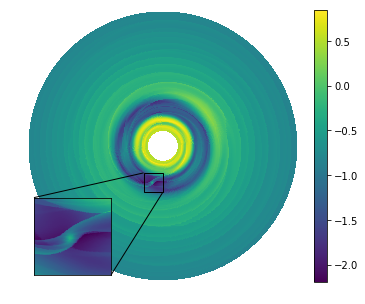

In [7]:
f1 = twod_plot(d, d.sigma_g, zoom=4, region=[-0.5, 0.0, -1.20, -0.70])
ax = f1.get_axes()[0]
ax.set_axis_off()
f1.savefig('xy_gas.pdf', facecolor='none', transparent=True, dpi=300)

## Total Dust Surface Density

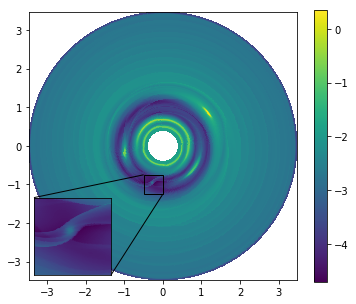

In [8]:
f1 = twod_plot(d, d.sigma_d.sum(-1), zoom=4, region=[-0.5, 0.0, -1.25, -0.75])

## Dust surface density of particles $\geq X$ 

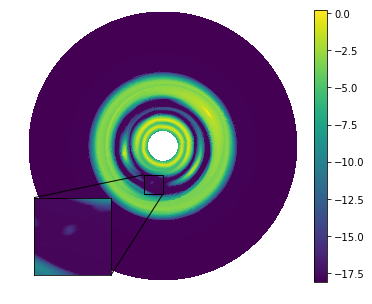

In [9]:
X  = 0.3 # minimum particle size in cm
ia = d.a.searchsorted(X)
f1 = twod_plot(d, d.sigma_d[:, :, ia:].sum(-1), zoom=4, region=[-0.5, 0.0, -1.25, -0.75])
ax = f1.get_axes()[0]
ax.set_axis_off()
f1.savefig('xy_mm.pdf', facecolor='none', transparent=True, dpi=300)

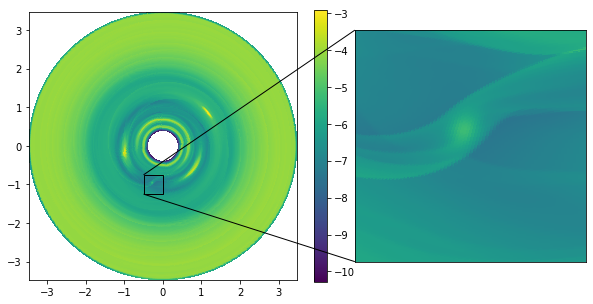

In [10]:
f2 = twod_plot(d, d.sigma_d[:, :, 10], zoom=12, region=[-0.5, 0.0, -1.25, -0.75], pos='r')

### Plot $a_\mathrm{max}$

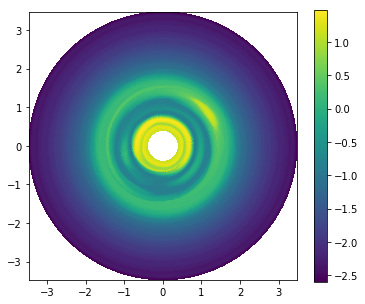

In [11]:
f3 = twod_plot(d, a_max, zoom=None, region=[0.65, 1.65, 0.5, 1.5], pos='r', bbox=(2.4, 0.5))

### Plot 1D (azimuthally averaged) gas and total dust

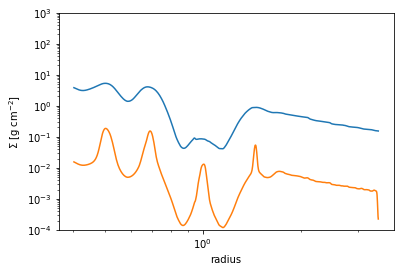

In [12]:
f, ax = plt.subplots()
ax.loglog(d.x, d.sigma_g[:, :].mean(1), label='gas')
ax.loglog(d.x, d.sigma_d[:, :, :].sum(-1).mean(-1), label='dust')
ax.set_xlabel('radius')
ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]')
ax.set_ylim(1e-4, 1e3)
f.savefig('sigma_avg.pdf')

### Plot azimuthally averaged size distribution

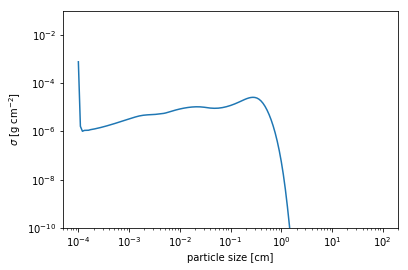

In [13]:
r  = 1.3
ir = d.x[()].searchsorted(r)

f, ax = plt.subplots()
ax.loglog(d.a, d.sigma_d[ir, :, :].mean(0))
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\sigma$ [g cm$^{-2}$]')
ax.set_ylim(1e-10, 1e-1)
f.savefig('size_at_{:.2g}.pdf'.format(r))

### Convert units and calculate Keplerian velocity

In [14]:
m_unit   = c.M_sun.cgs.value
m_star   = d.params['m_star'] * m_unit
m_disk   = d.params['M_DISK'] * m_unit
m_planet = d.params['mPlanet'] * m_unit

r_unit = c.au.cgs.value * d.params['r0_length']
r      = d.x * r_unit

t_unit = 1 / np.sqrt(c.G.cgs.value * m_star/ r_unit**3)

v_phi  = d.vp_g * r_unit / t_unit
v_k    = np.sqrt(c.G.cgs.value * m_star / (d.x * r_unit))

sig_g  = d.sigma_g * m_disk / r_unit**2
sig_d  = d.sigma_d * m_disk / r_unit**2

### Plot the $\Sigma_\mathrm{gas}$ to check conversion

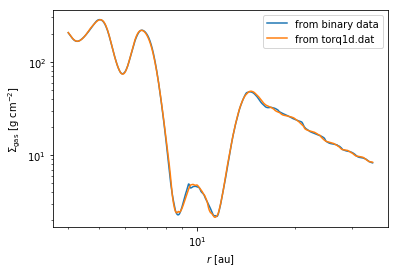

In [15]:
f, ax = plt.subplots()
ax.loglog(r / au, sig_g.mean(-1), label='from binary data')
ax.loglog(dt.r / au, dt.sigma_g[-1], label='from torq1d.dat')
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('$\Sigma_\mathrm{gas}$ [g cm$^{-2}$]')
ax.legend();

### Plot the azimuthal gas velocity deviation

Plot the radial profile to check conversion

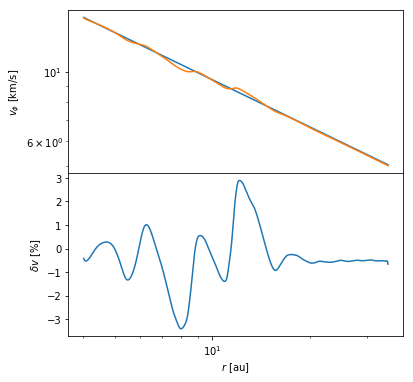

In [16]:
f, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax[0].loglog(r / au, (v_k * u.cm/u.s).to('km/s'))
ax[0].loglog(r / au, (v_phi.mean(-1) * u.cm/u.s).to('km/s'))
ax[1].semilogx(r / au, (v_phi.mean(-1)/v_k-1) * 100)
ax[0].set_ylabel('$v_\phi$ [km/s]')
ax[1].set_ylabel('$\delta v$ [%]')
ax[1].set_xlabel('$r$ [au]');
f.subplots_adjust(hspace=0)

### Create $\delta v$ plot like in Teague et al. 2018

/home/moon/birnstiel/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


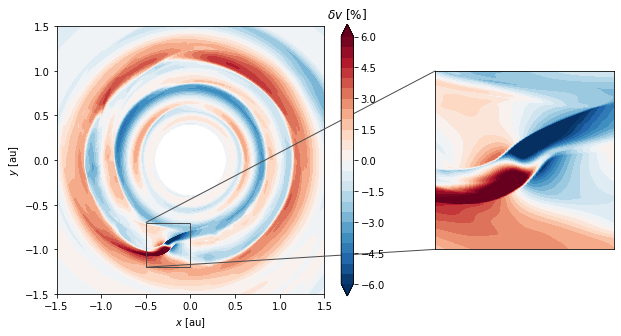

In [17]:
f = twod_plot(d, 10**((v_phi / v_k[:, None] - 1) * 100), ec='0.3',
              zoom=4, region=[-0.5, 0.0, -1.20, -0.70], pos='r',
              fct='contourf', levels=np.arange(-6,6.5,0.5),
              extend='both', cmap='RdBu_r')
ax = f.get_axes()[0]
R = 1.5
ax.set_xlim(-R, R)
ax.set_ylim(-R, R)
f.get_axes()[1].set_title('$\delta v$ [%]')
f.get_axes()[1].set_zorder(100)
ax.set_xlabel('$x$ [au]')
ax.set_ylabel('$y$ [au]')
f.savefig('delta_v.pdf', facecolor='none', transparent=True, dpi=300)

### Close the hdf5-file

In [18]:
f5.close()